<img src="https://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />

<!--- @wandbcode{keras-video} -->

# W&B 💘 Keras
Use Weights & Biases for machine learning experiment tracking, dataset versioning, and project collaboration.

<div><img /></div>

<img src="https://wandb.me/mini-diagram" width="650" alt="Weights & Biases" />

<div><img /></div>


<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/keras/Simple_Keras_Integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## What this notebook covers:

We show you how to integrate Weights & Biases with your Keras code to add experiment tracking to your pipeline. That includes:

1. Storing hyperparameters and metadata in a `config`.
2. Passing `WandbCallback` to `model.fit`. This will automatically log training metrics, like loss, and system metrics, like GPU and CPU utilization.
3. Using the `wandb.log` API to log custom metrics.

all using the CIFAR-10 dataset.

Then, we'll show you how to catch your model making mistakes by logging both the output predictions and the input images the network used to generate them.



## The resulting interactive W&B dashboard will look like:



![](https://i.imgur.com/SVo40sP.png)


## Follow along with a [video tutorial](http://wandb.me/keras-video)!
**Note**: Sections starting with _Step_ are all you need to integrate W&B in an existing pipeline. The rest just loads data and defines a model.

# Install, Import, and Log In

In [ ]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10

# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

### Step 0: Install W&B

In [ ]:
%%capture
!pip install wandb

### Step 1: Import W&B and Login

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

> Side note: If this is your first time using W&B or you are not logged in, the link that appears after running `wandb.login` will take you to sign-up/login page. Signing up is easy!

# Download and Prepare the Dataset


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Subsetting train data and normalizing to [0., 1.]
x_train, x_test = x_train[::5] / 255., x_test / 255.
y_train = y_train[::5]

CLASS_NAMES = ["airplane", "automobile", "bird", "cat",
               "deer", "dog", "frog", "horse", "ship", "truck"]

print('Shape of x_train: ', x_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of x_test: ', x_test.shape)
print('Shape of y_test: ', y_test.shape)

# Define the Model

Here, we define a standard CNN (with convolution and max-pooling) in Keras.

In [ ]:
def Model():
  inputs = keras.layers.Input(shape=(32, 32, 3))

  x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
  x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
  x = keras.layers.MaxPooling2D(pool_size=2)(x)

  x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
  x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)

  x = keras.layers.GlobalAveragePooling2D()(x)

  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dense(32, activation='relu')(x)
  
  outputs = keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(x)

  return keras.models.Model(inputs=inputs, outputs=outputs)

# Train the Model

### Step 2: Give `wandb.init` your `config`

You first initialize your wandb run, letting us know some training is about to happen. [Check out the official documentation for `.init` here $\rightarrow$](https://docs.wandb.com/library/init)

That's when you need to set your hyperparameters.
They're passed in as a dictionary via the `config` argument,
and then become available as the `config` attribute of `wandb`.

Learn more about `config` in this [Colab Notebook $\rightarrow$](http://wandb.me/config-colab)

In [ ]:
# Initialize wandb with your project name
run = wandb.init(project='my-keras-integration',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.005,
                     "epochs": 5,
                     "batch_size": 1024,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "CNN",
                     "dataset": "CIFAR-10"
                 })
config = wandb.config  # We'll use this to configure our experiment

# Initialize model like you usually do.
tf.keras.backend.clear_session()
model = Model()
model.summary()

# Compile model like you usually do.
# Notice that we use config, so our metadata matches what gets executed
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['acc'])

### Step 3: Pass `WandbCallback` to `model.fit`

Keras has a [robust callbacks system](https://keras.io/api/callbacks/) that
allows users to separate model definition and the core training logic
from other behaviors that occur during training and testing.

That includes, for example, 

**Click on the Project page link above to see your results!**

In [ ]:
# We train with our beloved model.fit
# Notice WandbCallback is used as a regular callback
# We again use config
_ = model.fit(x_train, y_train,
          epochs=config.epochs, 
          batch_size=config.batch_size,
          validation_data=(x_test, y_test),
          callbacks=[WandbCallback()])

# Use `wandb.log` for custom metrics

Here, we log the error rate on the test set.

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print('Test Error Rate: ', round((1 - accuracy) * 100, 2))

# With wandb.log, we can easily pass in metrics as key-value pairs.
wandb.log({'Test Error Rate': round((1 - accuracy) * 100, 2)})

run.finish()

# Log predictions on test data with `WandbCallback`

When machine learning models break, they usually don't throw errors. They fail silently, and the only way to detect them is to look at their behavior on examples. Without an experiment-tracking library, this requires writing a lot of extra code. That's time you're not spending training machines!

In this section, we demonstrate how this is easily done with the `WandbCallback` by logging both predictions on the test set and their matching images.

Let's take this opportunity to do a little experiment as well. We'll

* change learning rate from `0.005` to `0.001`.
* change batch size from `1024` to `32`.

In [ ]:
# Initialize wandb with your project name
run = wandb.init(project='my-keras-integration',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.001,
                     "epochs": 5,
                     "batch_size": 32,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "CNN",
                     "dataset": "CIFAR-10"
                 })
config = wandb.config  # We'll use this to configure our experiment

# Initialize model like you usually do.
tf.keras.backend.clear_session()
model = Model()
model.summary()

# Compile model like you usually do.
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['acc'])

In [ ]:
# We focus on a subset of images, since this is for human review
val_images, val_labels = x_test[:32], y_test[:32]

# Our beloved model.fit returns
# By passing arguments to WandbCallback, we change its behavior
_ = model.fit(x_train, y_train,
              epochs=config.epochs, 
              batch_size=config.batch_size,
              validation_data=(x_test, y_test),
              callbacks=[WandbCallback(data_type='image', 
                                       validation_data=(val_images, val_labels), 
                                       labels=CLASS_NAMES)])

run.finish()

# Visualize Results

Click on the **project page** link above to see your live results.

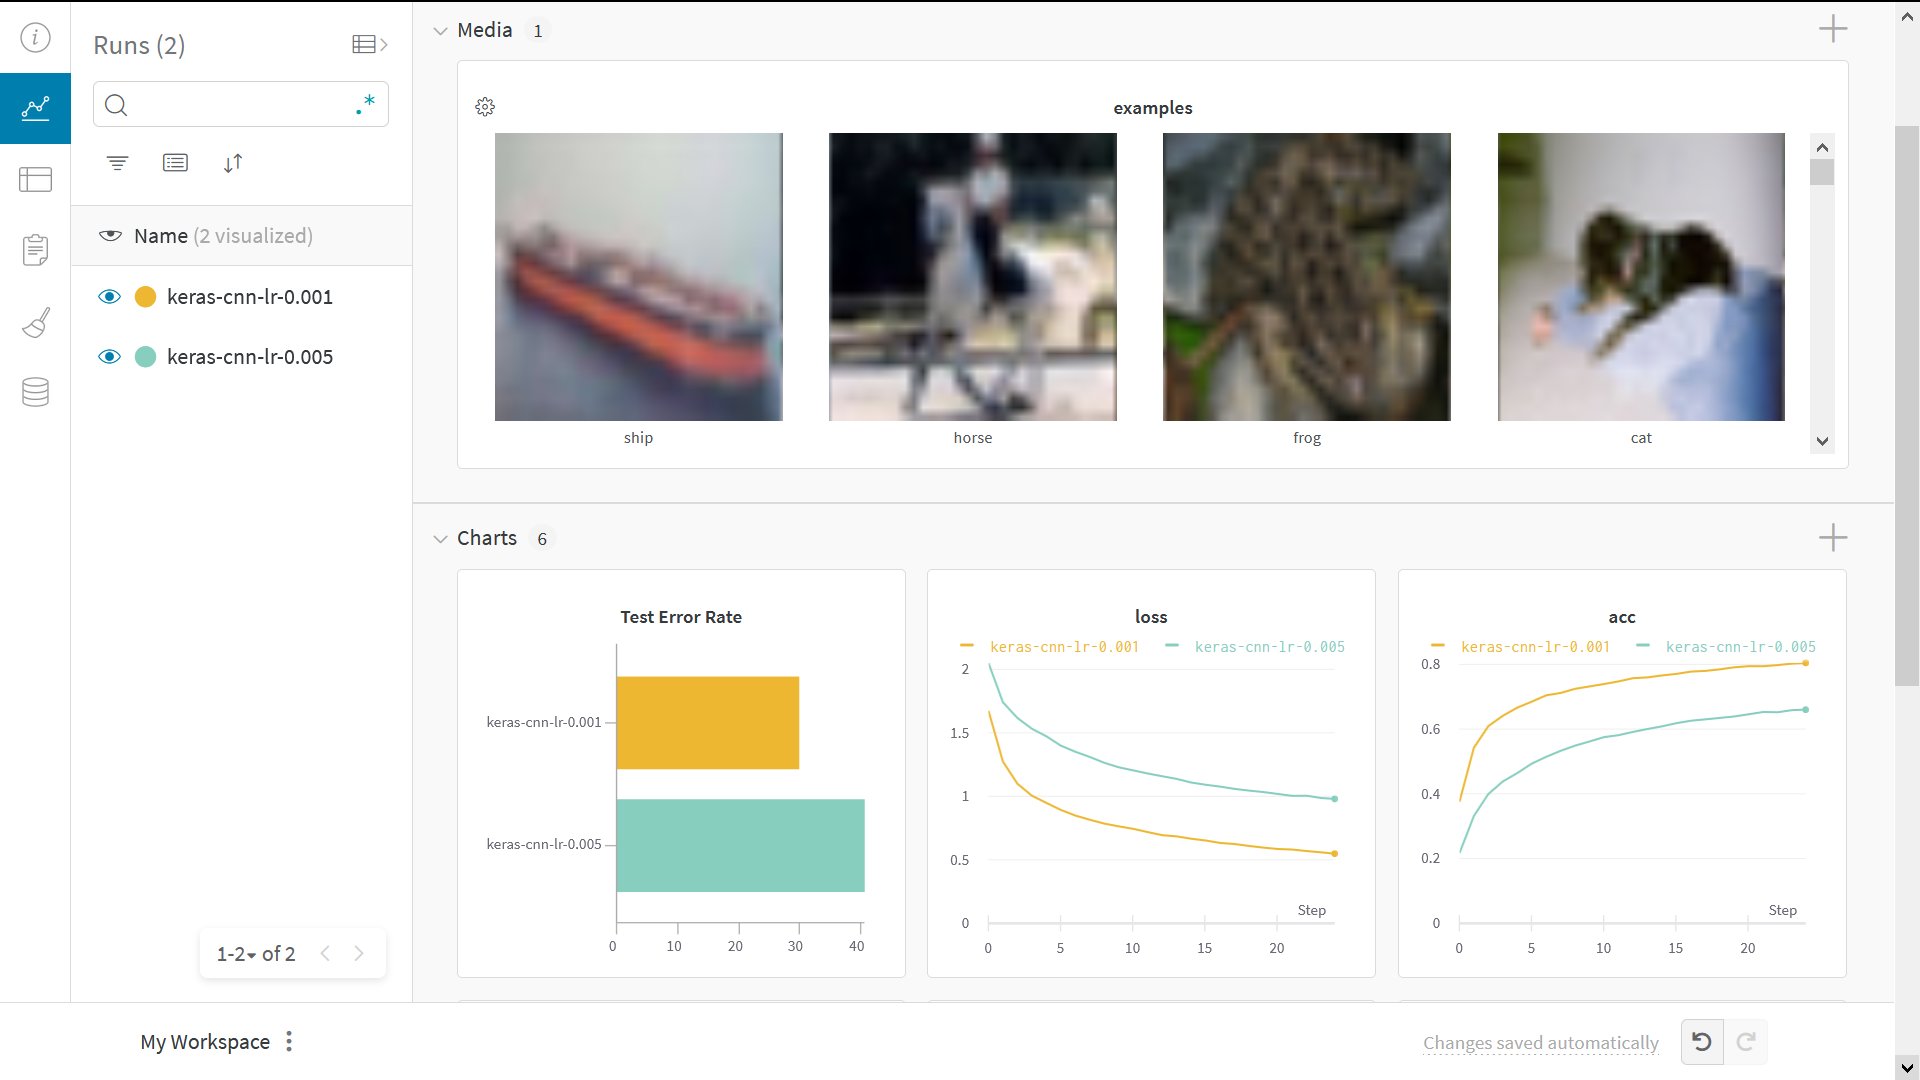

# Test Hyperparameters with Sweeps

We tried out two different hyperparameter settings by hand.

You can use Weights & Biases Sweeps to automate hyperparameter testing and explore the space of possible models and optimization strategies.

## [Check out Hyperparameter Optimization in TensorFlow uisng W&B Sweep $\rightarrow$](https://colab.research.google.com/drive/18TOgqiEsKxM0SMuIgBuDllE-dl9iisDz?usp=sharing)

Running a hyperparameter sweep with Weights & Biases is very easy. There are just 3 simple steps:

1. **Define the sweep:** We do this by creating a dictionary or a [YAML file](https://docs.wandb.com/library/sweeps/configuration) that specifies the parameters to search through, the search strategy, the optimization metric et all.

2. **Initialize the sweep:** 
`sweep_id = wandb.sweep(sweep_config)`

3. **Run the sweep agent:** 
`wandb.agent(sweep_id, function=train)`

And voila! That's all there is to running a hyperparameter sweep! In the notebook below, we'll walk through these 3 steps in more detail.

<img src="https://imgur.com/UiQKg0L.png" alt="Weights & Biases" />


# Example Gallery

See examples of projects tracked and visualized with W&B in our [Gallery →](https://app.wandb.ai/gallery)

# Basic Setup
1. **Projects**: Log multiple runs to a project to compare them. `wandb.init(project="project-name")`
2. **Groups**: For multiple processes or cross validation folds, log each process as a runs and group them together. `wandb.init(group='experiment-1')`
3. **Tags**: Add tags to track your current baseline or production model.
4. **Notes**: Type notes in the table to track the changes between runs.
5. **Reports**: Take quick notes on progress to share with colleagues and make dashboards and snapshots of your ML projects.

# Advanced Setup
1. [Environment variables](https://docs.wandb.com/library/environment-variables): Set API keys in environment variables so you can run training on a managed cluster.
2. [Offline mode](https://docs.wandb.com/library/technical-faq#can-i-run-wandb-offline): Use `dryrun` mode to train offline and sync results later.
3. [On-prem](https://docs.wandb.com/self-hosted): Install W&B in a private cloud or air-gapped servers in your own infrastructure. We have local installations for everyone from academics to enterprise teams.
4. [Sweeps](https://docs.wandb.com/sweeps): Set up hyperparameter search quickly with our lightweight tool for tuning.